## Importing libraries

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, GCNConv, SAGEConv # Graph Neural Network 
from torch_geometric.nn import global_mean_pool 
import rpy2.robjects as robjects # load R object 
from rpy2.robjects import pandas2ri # load R object 
from tqdm import tqdm # print progress bar 
import pickle # save object 
import matplotlib.pyplot as plt
import numpy as np
import random as rd 
import pandas as pd

Load trees and corresponding target parameters and convert them to pandas data.frame

In [2]:
pandas2ri.activate()

#fname_graph = "data/phylogeny-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1-graph.rds"
#fname_param = "data/true-param-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1.rds"

fname_graph = "data_clas/phylogeny-all-graph.rds"
fname_param = "data_clas/phylo-true-clas-all.rds"

readRDS = robjects.r['readRDS']
df_graph = readRDS(fname_graph)
df_graph = pandas2ri.rpy2py(df_graph)
df_param = readRDS(fname_param)
df_param = pandas2ri.rpy2py(df_param)


#df_param[2] = df_param[2]/100
#df_param[3] = df_param[3]/100

#removing crown age from predictions
#df_param = df_param[0:3]


# Simulating Indices

In [5]:
import random

preselected_sets = False
subset_size = 40000 # Specify the size of the subset
file_of_index = "data/10_3_indices_set_-DDD-Totalset-10000-SubSiz-10000-.rds" # to use the same as R

if preselected_sets == True:
    ind = readRDS(file_of_index) 
    ind = pandas2ri.rpy2py(ind)

    train, valid, test = ind
    train_ind, valid_ind, test_ind = list(train), list(valid), list(test)
    #print(train_ind[1])
    train_ind, valid_ind, test_ind = [i-1 for i in train_ind], [i-1 for i in valid_ind], [i-1 for i in test_ind]
    #print(train_ind[1])

else:
    #total_data_points = len(df_graph)
    total_data_points = 40000
    subset_size = 40000-1  # Specify the size of the subset

    n_train = int(subset_size * 0.9)
    n_valid = int(subset_size * 0.05)
    n_test = subset_size - n_train - n_valid
    batch_size = min(int(subset_size * 0.01), 10)

    # Pick the phylogenies randomly.
    #true[2] = true[2] / 100
    #true[3] = true[3] / 100
    #ds = convert_encode_to_dataset(cblv, true)

    # Pick the random subset of data points.
    subset_indices = random.sample(range(1, total_data_points), subset_size)

    # Split the subset into train, validation, and test indices.
    train_ind = subset_indices[:n_train]
    valid_ind = subset_indices[n_train:(n_train + n_valid)]
    test_ind = subset_indices[(n_train + n_valid):subset_size]

Checking the total number of trees of the dataset (n_trees) and the number of target parameters for each tree (n_param)

In [6]:
n_param = len(df_param)
n_trees = len(df_graph)

In [7]:
def convert_df_to_tensor(df_node, df_edge, params):

    """
    Convert the data frames containing node and edge information 
    to a torch tensor that can be used to feed neural 
    """

    n_node, n_edge = df_node.shape[0], df_edge.shape[0]
    #n_node, n_edge = int(robjects.r("nrow")(df_node)[0]), int(robjects.r("nrow")(df_edge)[0])

    #pandas_df_node = pd.DataFrame(df_node)
    #pandas_df_edge = pandas2ri.ri2py_dataframe(df_edge)

    l1, l2 = [], []
    
    for i in range(n_edge):
        #print(type(pandas_df_node))
        edge = df_edge.iloc[i]
        u, v = edge[0]-1, edge[1]-1
        l1 = l1 + [u,v]
        l2 = l2 + [v,u]

    edge_index = torch.tensor([l1,l2], dtype=torch.long)

    x = []

    for i in range(n_node):
        node_attr = list(df_node.iloc[i])
        x.append(node_attr)

    x = torch.tensor(x, dtype = torch.float)

    y = torch.tensor(params, dtype = torch.float)

    data = Data(x = x, edge_index = edge_index, y = y)

    return(data)

# Preparing data for training

In [254]:
batch_size_max = 64
data_list  = []

for n in tqdm(range(20000)):
    df_node, df_edge = df_graph[n][0], df_graph[n][1]
    params = [df_param[i][n] for i in range(n_param)]
    data = convert_df_to_tensor( pandas2ri.rpy2py(df_node), pandas2ri.rpy2py(df_edge), params)
    data_list.append(data)

#dataloader = DataLoader(data_list, batch_size=batch_size_max)

100%|██████████| 20000/20000 [14:55:53<00:00,  2.69s/it]      


Save or load dataset

In [10]:
fname_param[:-9]

'data_clas/true-param-all-'

In [8]:
save = True

fname = fname_param[:-9] + "geomtensor" + ".obj" # file name 
if (save):
    print("Save")
    file = open(fname, "wb") # file handler 
    pickle.dump(data_list, file) # save data_list

else:
    print("Load")
    file = open(fname, "rb")
    data_list = pickle.load(file) 

Load


In [5]:
print("Load")
file = open(fname, "rb")
data_list = pickle.load(file) 

Load


NameError: name 'fname' is not defined

Split dataset into train, valid and test set.

In [263]:
print(data_list[2999].y)

tensor([0., 1., 0., 0.])


In [9]:
#device = "cuda:2" # GPU to use 
device="cpu"
batch_size_max = 32


train_data = [data_list[i].to(device=device) for i in train_ind]
valid_data = [data_list[i].to(device=device) for i in valid_ind]
test_data  = [data_list[i].to(device=device) for i in test_ind]

train_dl = DataLoader(train_data, batch_size = batch_size_max, shuffle = True)
valid_dl = DataLoader(valid_data, batch_size = batch_size_max, shuffle = True)
test_dl  = DataLoader(test_data , batch_size = 1)

Create the GNN structure

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.conv1 = GCNConv(n_in, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.conv3 = GCNConv(n_hidden, n_hidden)
        self.conv4 = GCNConv(n_hidden, n_hidden)
        self.conv5 = GCNConv(n_hidden, 2*n_hidden)
        self.lin1  = torch.nn.Linear(2*n_hidden, n_hidden)
        self.lin2  = torch.nn.Linear(n_hidden, n_out)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

In [11]:
def train(model, batch):
    optimizer.zero_grad()
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.cross_entropy(out, data.y.reshape([batch_size, n_out])) # compute loss 
    loss.backward() # backward propagation 
    optimizer.step()
    acc=torch.sum(torch.argmax(data.y.reshape([batch_size, n_out]),axis=1)==torch.argmax(out,dim=1)).item()
    return(loss,acc/batch_size)

def valid(model, batch):
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.cross_entropy(out, data.y.reshape([batch_size, n_out])) # compute loss
    acc=torch.sum(torch.argmax(data.y.reshape([batch_size, n_out]),axis=1)==torch.argmax(out,dim=1)).item()
    #total = out.size(dim=0)
    return(loss,acc/batch_size)


In [245]:
data_list[1000].num_node_features


6

In [12]:
# Setting up the training 
n_in = data_list[0].num_node_features
n_out = len(data_list[0].y)
n_hidden = 100
n_epochs = 100
model = GCN(n_in, n_hidden, n_out).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = F.cross_entropy

In [13]:

valid_list = []
train_list = []

train_acc_list = []
valid_acc_list = []


patience = 10  # Number of epochs to wait for improvement
best_loss = float('inf')
best_epoch = 0

early_stop = False
counter = 0



# Training loop 

for epoch in range(n_epochs):
    if early_stop:
        break

    # Training
    model.train()
    train_loss = []
    train_acc = []
    for data in tqdm(train_dl):
        loss , acc = train(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        train_loss.append(loss)
        train_acc.append(acc)
    mean_loss = np.mean(train_loss)
    mean_acc = np.mean(train_acc)

    train_list.append(mean_loss)
    train_acc_list.append(mean_acc)

    print("Epoch %d - Train Loss : %.4f Train Acc : %.4f" % (epoch, float(mean_loss),float(mean_acc)))  # print progression

    # Validation
    model.eval()
    valid_loss = []
    valid_acc = []
    for data in tqdm(valid_dl):
        loss,acc = valid(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        valid_loss.append(loss)
        valid_acc.append(acc)
    mean_loss = np.mean(valid_loss)
    mean_acc = np.mean(valid_acc)


    valid_list.append(mean_loss)
    valid_acc_list.append(mean_acc)
    print("Epoch %d - Valid Loss : %.4f Train Acc : %.4f" % (epoch, float(mean_loss),float(mean_acc)))  # print progression

    # Check for early stopping
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch %d" % (epoch))
            early_stop = True

print("Best epoch:", best_epoch)

100%|██████████| 1125/1125 [11:37<00:00,  1.61it/s]


Epoch 0 - Train Loss : 0.7233 Train Acc : 0.5057


100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


Epoch 0 - Valid Loss : 0.7037 Train Acc : 0.4801


100%|██████████| 1125/1125 [11:18<00:00,  1.66it/s]


Epoch 1 - Train Loss : 0.7016 Train Acc : 0.5101


100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch 1 - Valid Loss : 0.7014 Train Acc : 0.4876


100%|██████████| 1125/1125 [11:41<00:00,  1.60it/s]


Epoch 2 - Train Loss : 0.7033 Train Acc : 0.5037


100%|██████████| 63/63 [00:24<00:00,  2.59it/s]


Epoch 2 - Valid Loss : 0.7222 Train Acc : 0.4807


100%|██████████| 1125/1125 [12:51<00:00,  1.46it/s]


Epoch 3 - Train Loss : 0.7039 Train Acc : 0.5043


100%|██████████| 63/63 [00:22<00:00,  2.86it/s]


Epoch 3 - Valid Loss : 0.6969 Train Acc : 0.5182


100%|██████████| 1125/1125 [12:50<00:00,  1.46it/s]


Epoch 4 - Train Loss : 0.6993 Train Acc : 0.5087


100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


Epoch 4 - Valid Loss : 0.6980 Train Acc : 0.5215


100%|██████████| 1125/1125 [12:14<00:00,  1.53it/s]


Epoch 5 - Train Loss : 0.6977 Train Acc : 0.5171


100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch 5 - Valid Loss : 0.6922 Train Acc : 0.4861


100%|██████████| 1125/1125 [12:31<00:00,  1.50it/s]


Epoch 6 - Train Loss : 0.7002 Train Acc : 0.5101


100%|██████████| 63/63 [00:23<00:00,  2.64it/s]


Epoch 6 - Valid Loss : 0.7101 Train Acc : 0.4801


100%|██████████| 1125/1125 [12:55<00:00,  1.45it/s]


Epoch 7 - Train Loss : 0.7012 Train Acc : 0.5093


100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch 7 - Valid Loss : 0.6967 Train Acc : 0.5221


100%|██████████| 1125/1125 [12:41<00:00,  1.48it/s]


Epoch 8 - Train Loss : 0.7032 Train Acc : 0.5108


100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


Epoch 8 - Valid Loss : 0.6910 Train Acc : 0.5302


100%|██████████| 1125/1125 [11:00<00:00,  1.70it/s]


Epoch 9 - Train Loss : 0.6958 Train Acc : 0.5168


100%|██████████| 63/63 [00:27<00:00,  2.29it/s]


Epoch 9 - Valid Loss : 0.7001 Train Acc : 0.5209


100%|██████████| 1125/1125 [13:07<00:00,  1.43it/s]


Epoch 10 - Train Loss : 0.6953 Train Acc : 0.5193


100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 10 - Valid Loss : 0.6885 Train Acc : 0.5214


100%|██████████| 1125/1125 [12:00<00:00,  1.56it/s]


Epoch 11 - Train Loss : 0.6985 Train Acc : 0.5072


100%|██████████| 63/63 [00:21<00:00,  2.94it/s]


Epoch 11 - Valid Loss : 0.7017 Train Acc : 0.5214


100%|██████████| 1125/1125 [12:07<00:00,  1.55it/s]


Epoch 12 - Train Loss : 0.7049 Train Acc : 0.5057


100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch 12 - Valid Loss : 0.7077 Train Acc : 0.4813


100%|██████████| 1125/1125 [13:48<00:00,  1.36it/s]


Epoch 13 - Train Loss : 0.7033 Train Acc : 0.4968


100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


Epoch 13 - Valid Loss : 0.6986 Train Acc : 0.5178


100%|██████████| 1125/1125 [13:59<00:00,  1.34it/s]


Epoch 14 - Train Loss : 0.7058 Train Acc : 0.5031


100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


Epoch 14 - Valid Loss : 0.6947 Train Acc : 0.5193


100%|██████████| 1125/1125 [12:37<00:00,  1.49it/s]


Epoch 15 - Train Loss : 0.7064 Train Acc : 0.4966


100%|██████████| 63/63 [00:27<00:00,  2.27it/s]


Epoch 15 - Valid Loss : 0.6975 Train Acc : 0.5193


100%|██████████| 1125/1125 [12:21<00:00,  1.52it/s]


Epoch 16 - Train Loss : 0.7022 Train Acc : 0.4975


100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 16 - Valid Loss : 0.7143 Train Acc : 0.4808


100%|██████████| 1125/1125 [12:00<00:00,  1.56it/s]


Epoch 17 - Train Loss : 0.6981 Train Acc : 0.5127


100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 17 - Valid Loss : 0.6859 Train Acc : 0.5194


100%|██████████| 1125/1125 [11:55<00:00,  1.57it/s]


Epoch 18 - Train Loss : 0.7013 Train Acc : 0.5180


100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Epoch 18 - Valid Loss : 0.6916 Train Acc : 0.5214


100%|██████████| 1125/1125 [11:55<00:00,  1.57it/s]


Epoch 19 - Train Loss : 0.6952 Train Acc : 0.5331


100%|██████████| 63/63 [00:20<00:00,  3.12it/s]


Epoch 19 - Valid Loss : 0.7089 Train Acc : 0.5180


100%|██████████| 1125/1125 [10:34<00:00,  1.77it/s]


Epoch 20 - Train Loss : 0.6927 Train Acc : 0.5312


100%|██████████| 63/63 [00:20<00:00,  3.01it/s]


Epoch 20 - Valid Loss : 0.6990 Train Acc : 0.5617


100%|██████████| 1125/1125 [10:41<00:00,  1.75it/s]


Epoch 21 - Train Loss : 0.6939 Train Acc : 0.5312


100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


Epoch 21 - Valid Loss : 0.7004 Train Acc : 0.5240


100%|██████████| 1125/1125 [10:14<00:00,  1.83it/s]


Epoch 22 - Train Loss : 0.6931 Train Acc : 0.5270


100%|██████████| 63/63 [00:19<00:00,  3.31it/s]


Epoch 22 - Valid Loss : 0.6844 Train Acc : 0.5530


100%|██████████| 1125/1125 [10:24<00:00,  1.80it/s]


Epoch 23 - Train Loss : 0.6980 Train Acc : 0.5282


100%|██████████| 63/63 [00:18<00:00,  3.38it/s]


Epoch 23 - Valid Loss : 0.6901 Train Acc : 0.5258


100%|██████████| 1125/1125 [10:23<00:00,  1.80it/s]


Epoch 24 - Train Loss : 0.6948 Train Acc : 0.5272


100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch 24 - Valid Loss : 0.7030 Train Acc : 0.5182


100%|██████████| 1125/1125 [10:18<00:00,  1.82it/s]


Epoch 25 - Train Loss : 0.6944 Train Acc : 0.5317


100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


Epoch 25 - Valid Loss : 0.6862 Train Acc : 0.5173


100%|██████████| 1125/1125 [10:25<00:00,  1.80it/s]


Epoch 26 - Train Loss : 0.6984 Train Acc : 0.5288


100%|██████████| 63/63 [00:18<00:00,  3.34it/s]


Epoch 26 - Valid Loss : 0.6961 Train Acc : 0.4801


100%|██████████| 1125/1125 [10:24<00:00,  1.80it/s]


Epoch 27 - Train Loss : 0.6954 Train Acc : 0.5195


100%|██████████| 63/63 [00:20<00:00,  3.13it/s]


Epoch 27 - Valid Loss : 0.6946 Train Acc : 0.5070


100%|██████████| 1125/1125 [10:27<00:00,  1.79it/s]


Epoch 28 - Train Loss : 0.6970 Train Acc : 0.5176


100%|██████████| 63/63 [00:18<00:00,  3.35it/s]


Epoch 28 - Valid Loss : 0.6932 Train Acc : 0.5127


100%|██████████| 1125/1125 [10:29<00:00,  1.79it/s]


Epoch 29 - Train Loss : 0.6943 Train Acc : 0.5200


100%|██████████| 63/63 [00:18<00:00,  3.35it/s]


Epoch 29 - Valid Loss : 0.6905 Train Acc : 0.5378


100%|██████████| 1125/1125 [10:46<00:00,  1.74it/s]


Epoch 30 - Train Loss : 0.6970 Train Acc : 0.5161


100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


Epoch 30 - Valid Loss : 0.6918 Train Acc : 0.5054


100%|██████████| 1125/1125 [13:32<00:00,  1.38it/s]


Epoch 31 - Train Loss : 0.6962 Train Acc : 0.5175


100%|██████████| 63/63 [00:22<00:00,  2.86it/s]


Epoch 31 - Valid Loss : 0.6884 Train Acc : 0.5360


100%|██████████| 1125/1125 [14:32<00:00,  1.29it/s]


Epoch 32 - Train Loss : 0.6960 Train Acc : 0.5187


100%|██████████| 63/63 [00:21<00:00,  2.97it/s]

Epoch 32 - Valid Loss : 0.6986 Train Acc : 0.4985
Early stopping at epoch 32
Best epoch: 22


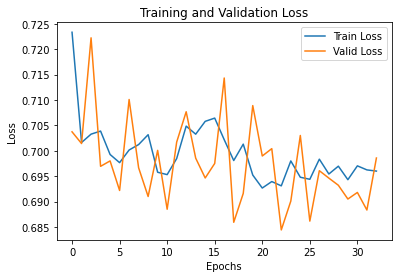

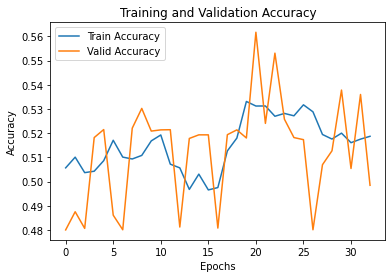

In [14]:
# Plotting the training and validation loss
epochs = range(len(train_list))

plt.plot(epochs, train_list, label='Train Loss')
plt.plot(epochs, valid_list, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


epochs = range(len(train_list))

plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, valid_acc_list, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [20]:
# Specify the file path to save the model
file_path = 'GNN_phylo_class.pt'

# Save the model
torch.save(model.state_dict(), file_path)

In [18]:
#model.load_state_dict(torch.load('GNN_phylo_class.pt'))

<All keys matched successfully>

In [15]:
#test_dl = DataLoader(data_list[:500], batch_size = 1)
n_param = len(df_param)
pred_list, true_list = [[0,0,0,0] for n in range(n_param)], [[] for n in range(n_param)]
acc_sum = [0 ,0 ,0 ,0 ,0]
total_sum = [0 ,0 ,0 ,0 ,0]



model.eval()
for data in test_dl:
    out = model(data.to(device=device))
    pred_params = torch.argmax(out,dim=1)[0]
    true_params = torch.argmax(data.y,axis=0)

    acc = torch.sum(torch.argmax(data.y,axis=0)==torch.argmax(out,dim=1)[0]).item()


    pred_list[true_params][pred_params]+=1




    if (true_params == 0):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1

    elif (true_params == 1):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1
    
    elif (true_params == 2):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1
    
    elif (true_params == 3):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1

acc_sum[4]    =   sum(acc_sum[:-1])
total_sum[4]  =   sum(total_sum[:-1])





In [19]:
print(acc_sum)
print(total_sum)
print(pred_list)

[73, 473, 513, 0, 1059]
[507, 503, 513, 478, 2001]
[[73, 434, 0, 0], [30, 473, 0, 0], [0, 0, 513, 0], [0, 0, 478, 0]]


In [17]:
result = [a / b if b != 0 else 0 for a, b in zip(acc_sum, total_sum)]

print("Accuracy pred CRBD: %.3f ,Bisse: %.3f ,DDD: %.3f ,PLD: %.3f ,Total: %.3f   " % tuple(result))


Accuracy pred CRBD: 0.144 ,Bisse: 0.940 ,DDD: 1.000 ,PLD: 0.000 ,Total: 0.529   


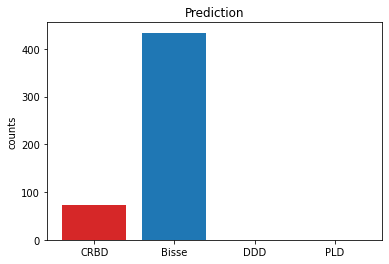

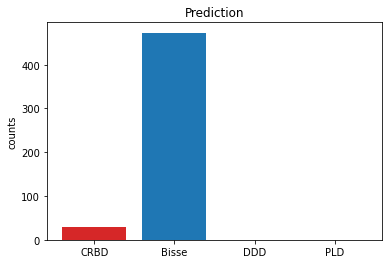

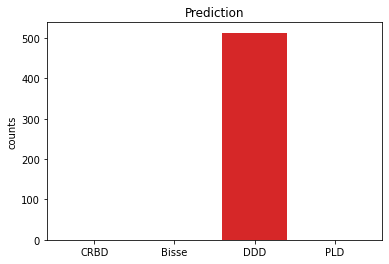

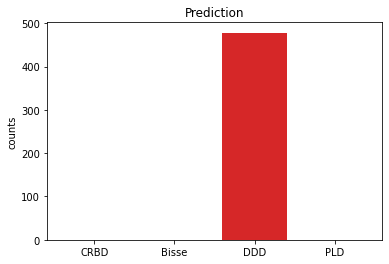

In [18]:
for i, sublist in enumerate(pred_list):
    fig, ax = plt.subplots()

    preds = ['CRBD', 'Bisse', 'DDD', 'PLD']
    counts = sublist
    bar_labels = ['red', 'blue', 'red', 'orange']
    bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

    ax.bar(preds, counts, color=bar_colors)

    ax.set_ylabel('counts')
    ax.set_title('Prediction')

    plt.show()

